In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

In [3]:
# !unzip /content/duck_chick_dataset.zip

In [4]:
train_path="/content/duck_chick_dataset/train"
test_path="/content/duck_chick_dataset/test"
val_path="/content/duck_chick_dataset/val"

Display some images from the training dataset

Displaying Chicken Images:


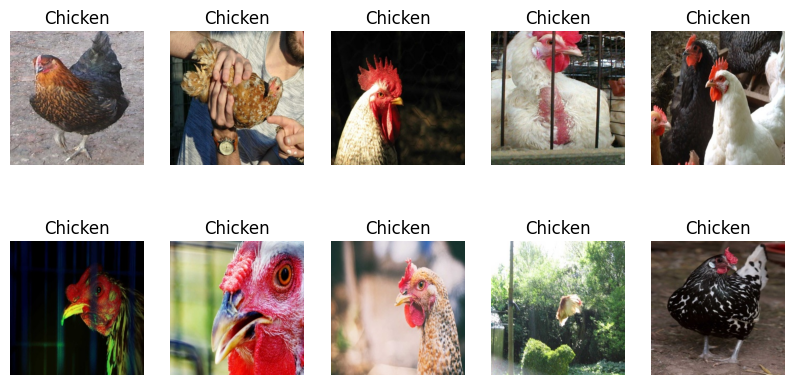

Displaying Duck Images:


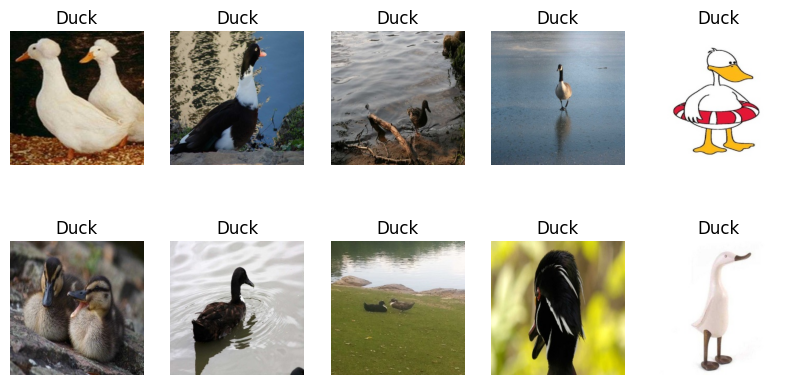

In [5]:
# Path to the directories containing chicken and duck images
chicken_dir = "/content/duck_chick_dataset/train/chicken"
duck_dir = "/content/duck_chick_dataset/train/duck"

# Function to display annotated images
def display_images(directory):
    fig = plt.figure(figsize=(10, 5))
    images = os.listdir(directory)
    for i in range(10):  # Displaying 10 images
        img = mpimg.imread(os.path.join(directory, images[i]))
        ax = fig.add_subplot(2, 5, i+1)
        ax.imshow(img)
        ax.axis('off')
        if 'chicken' in directory:
            ax.set_title('Chicken')
        else:
            ax.set_title('Duck')
    plt.show()

# Display chicken images
print("Displaying Chicken Images:")
display_images(chicken_dir)

# Display duck images
print("Displaying Duck Images:")
display_images(duck_dir)


In [6]:
x_train=[]

for folder in os.listdir(train_path):
    sub_path=train_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_train.append(img_arr)

In [7]:
x_test=[]

for folder in os.listdir(test_path):
    sub_path=test_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_test.append(img_arr)

In [8]:
x_val=[]

for folder in os.listdir(val_path):
    sub_path=val_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_val.append(img_arr)

In [9]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)

In [10]:
train_x.shape,test_x.shape,val_x.shape

((128, 224, 224, 3), (40, 224, 224, 3), (32, 224, 224, 3))

Normalising

In [11]:
train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)


training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'binary')

val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 128 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Found 32 images belonging to 2 classes.


In [14]:
training_set.class_indices

{'chicken': 0, 'duck': 1}

In [15]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

In [16]:
train_y.shape,test_y.shape,val_y.shape

((128,), (40,), (32,))

In [17]:
# add preprocessing layer to the front of VGG
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [18]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [19]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)

prediction = Dense(1, activation='sigmoid')(x)

In [20]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [21]:
# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [22]:
# fit the model
history = model.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=10,
  batch_size=32,shuffle=True)

Epoch 1/10
4/4 [==============================] - 12s 542ms/step - loss: 1.1411 - accuracy: 0.4609 - val_loss: 1.1597 - val_accuracy: 0.5000
Epoch 2/10
4/4 [==============================] - 1s 283ms/step - loss: 0.7763 - accuracy: 0.5859 - val_loss: 0.6561 - val_accuracy: 0.6562
Epoch 3/10
4/4 [==============================] - 1s 313ms/step - loss: 0.5713 - accuracy: 0.6797 - val_loss: 0.5535 - val_accuracy: 0.6875
Epoch 4/10
4/4 [==============================] - 1s 307ms/step - loss: 0.3879 - accuracy: 0.8438 - val_loss: 0.8654 - val_accuracy: 0.5938
Epoch 5/10
4/4 [==============================] - 1s 244ms/step - loss: 0.2887 - accuracy: 0.8672 - val_loss: 0.5795 - val_accuracy: 0.5938
Epoch 6/10
4/4 [==============================] - 1s 265ms/step - loss: 0.2501 - accuracy: 0.8984 - val_loss: 0.6001 - val_accuracy: 0.6250
Epoch 7/10
4/4 [==============================] - 1s 240ms/step - loss: 0.1658 - accuracy: 0.9609 - val_loss: 0.6219 - val_accuracy: 0.7188
Epoch 8/10
4/4 [===

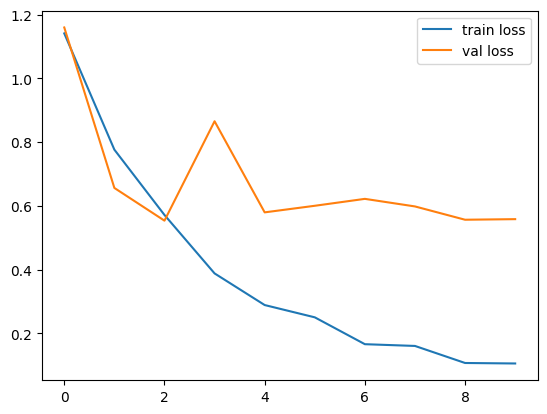

In [23]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

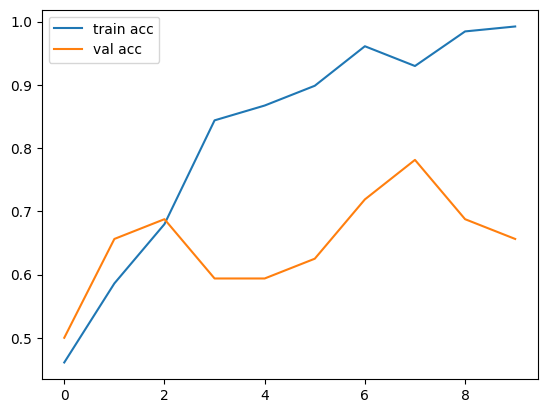

In [24]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [25]:
model.evaluate(test_x,test_y,batch_size=32)

2/2 [==============================] - 3s 2s/step - loss: 0.3721 - accuracy: 0.9000


[0.372086763381958, 0.8999999761581421]

In [26]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

In [27]:
y_pred=model.predict(test_x)
y_pred=(y_pred > 0.5).astype(int)

2/2 [==============================] - 0s 152ms/step


In [28]:
accuracy_score(y_pred,test_y)

0.9

In [29]:
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89        18
           1       0.95      0.86      0.90        22

    accuracy                           0.90        40
   macro avg       0.90      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40



In [30]:
confusion_matrix(y_pred,test_y)

array([[17,  1],
       [ 3, 19]])